# Imports

In [1]:
import torch
import torchvision 
import torch.nn.functional as F 
import torchvision.datasets as datasets  
import torchvision.transforms as transforms
from torch import optim  
from torch import nn  
from torch.utils.data import DataLoader 
from tqdm import tqdm  
import timeit
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

## Download dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


## Preparing dataloader

In [3]:
def get_data_loader(dataset):
  
  left_imgs, right_imgs = split_images(dataset)
  data = []
  for idx, img in enumerate(x_train):
    left = img[:,:14]
    right = img[:,14:]
    data.append((left,right))
  data = np.array(data)

  X = torch.tensor(data)
  loader = DataLoader(dataset=X, batch_size=64, shuffle=True)

  return loader

## Splitting dataset into left and right images

In [4]:
def split_images(data):
  left_imgs = np.zeros((60000,28,14))
  right_imgs = np.zeros((60000,28,14))
  for idx, img in enumerate(data):
      left_imgs[idx] = img[:,:14]
      right_imgs[idx] = img[:,14:]
  return left_imgs, right_imgs

In [5]:
train_loader = get_data_loader(x_train)

In [6]:
#### WILL REMOVE THIS CELL LATER
for x in train_loader:
    print(x.shape)
    x = x.reshape(64,1,2,28,14)
    print(x.shape)
    break

torch.Size([64, 2, 28, 14])
torch.Size([64, 1, 2, 28, 14])


# Autoencoder
### Feeding  batch of 64 imgs to left half feed and right half feed b4 the merged middle layer in the network

64 x 10 dimension output for both ;eft and right img batch as we have 64 imgs and embeddings are of size 10 as of now

In [42]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()        
        ### ENCODING
        self.convleft1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.poolleft1 = nn.MaxPool2d(2, 2)  # 8*14*7
        # self.bn1=nn.BatchNorm2d(8, 1e-05, 0.1)
        self.convleft2 = nn.Conv2d(8, 24, kernel_size=3, stride=1, padding=1)
        self.poolleft2 = nn.MaxPool2d(2, 2) # 24*7*3
        # self.bn2=nn.BatchNorm2d(24, 1e-05, 0.1)
        self.fcleft1 = nn.Linear(24*7*3, 64)
        self.fcleft2 = nn.Linear(64, 32)
        self.fcleft3 = nn.Linear(32, 10)
        
        self.convright1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.poolright1 = nn.MaxPool2d(2, 2)  # 8*14*7
        self.convright2 = nn.Conv2d(8, 24, kernel_size=3, stride=1, padding=1)
        self.poolright2 = nn.MaxPool2d(2, 2) # 24*7*3
        self.fcright1 = nn.Linear(24*7*3, 64)
        self.fcright2 = nn.Linear(64, 32)
        self.fcright3 = nn.Linear(32, 10)

        # ### DECODING
        # self.linearleft = nn.Linear(20, 392)
        # self.linearright = nn.Linear(20, 392)

        ### DECODING
        self.linearleft1 = nn.Linear(20, 64)
        self.linearleft2 = nn.Linear(64, 24*7*3)
        # self.unpoolleft1 = nn.MaxUnpool2d(2, 2)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconvleft1 = nn.ConvTranspose2d(24, 8, kernel_size=3, stride=1, padding=1)
        # self.unpoolleft2 = nn.MaxUnpool2d(2, 2)
        # upsampling is used here in this sequence again
        self.deconvleft2 = nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1) 
        # self.linearleft = nn.Linear(20, 392)

        self.linearright1 = nn.Linear(20, 64)
        self.linearright2 = nn.Linear(64, 24*7*3)
        # self.unpoolright1 = nn.MaxUnpool2d(2, 2)
        self.deconvright1 = nn.ConvTranspose2d(24, 8, kernel_size=3, stride=1, padding=1)
        # self.unpoolright2 = nn.MaxUnpool2d(2, 2)
        self.deconvright2 = nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1)
        # self.linearright = nn.Linear(20, 392)
        
    def feed_left(self, x):
        plt.imshow(x[0,0,:,:])
        plt.show()

    def feed_right(self, x):
        plt.imshow(x[0,0,:,:])
        plt.show()
        
    def forward(self, x):
        # #ENCODING
        # left = x[:,:,0,:,:]
        # right = x[:,:,1,:,:]

        # # print(left.shape, right.shape)
        
        # #  LEFT FIRST HALF
        # x = F.relu(self.convleft1(left))
        # x = self.poolleft1(x)
        # x = F.relu(self.convleft2(x))
        # x = self.poolleft2(x)
        # x = x.reshape(64,-1) 
        # hleft1 = F.relu(self.fcleft1(x))
        # hleft2 = F.relu(self.fcleft2(hleft1))
        # hleft3 = F.relu(self.fcleft3(hleft2))

        # # RIGHT FIRST HALF
        # y = F.relu(self.convright1(right))
        # y = self.poolright1(y)
        # y = F.relu(self.convright2(y))
        # y = self.poolright2(y)
        # y = y.reshape(64,-1) 
        # hright1 = F.relu(self.fcright1(y))
        # hright2 = F.relu(self.fcright2(hright1))
        # hright3 = F.relu(self.fcright3(hright2))
        
        # #MERGE
        # hcommon = torch.cat((hleft3, hright3), 1)
        # # print(hcommon.shape)
        
        # #DECODING
        # recleft = F.relu(self.linearleft(hcommon))
        # recright = F.relu(self.linearright(hcommon))
        
        # #Here output image is of dimension 392, need to reshape it to 28x14
        # # print(recleft.shape, recright.shape )
        # # recleft = recleft.reshape(64, 1, 1, 28, 14)
        # # recright = recright.reshape(64, 1, 1, 28, 14)
        
        # return(hcommon, recleft, recright, hleft1, hleft2, hright1, hright2)


        #ENCODING
        left = x[:,:,0,:,:]
        right = x[:,:,1,:,:]
        
        #  LEFT FIRST HALF
        x = F.relu(self.convleft1(left))
        x = self.poolleft1(x)
        # x = self.bn1(x)
        x = F.relu(self.convleft2(x))
        x = self.poolleft2(x)
        # x = self.bn2(x)
        x = x.reshape(64,-1) 
        hleft1 = F.relu(self.fcleft1(x))
        hleft2 = F.relu(self.fcleft2(hleft1))
        hleft3 = F.relu(self.fcleft3(hleft2))

        # RIGHT FIRST HALF
        y = F.relu(self.convright1(right))
        y = self.poolright1(y)
        y = F.relu(self.convright2(y))
        y = self.poolright2(y)
        y = y.reshape(64,-1) 
        hright1 = F.relu(self.fcright1(y))
        hright2 = F.relu(self.fcright2(hright1))
        hright3 = F.relu(self.fcright3(hright2))
        
        #MERGE
        hcommon = torch.cat((hleft3, hright3), 1)
        #print("hcommon ",hcommon.shape)

        #DECODING
        # recleft = F.relu(self.linearleft(hcommon))
        a = F.relu(self.linearleft1(hcommon))
        a = F.relu(self.linearleft2(a))
        # a = self.unpoolleft1(a, left_indices2)
        a = self.upsample1(a)
        a = F.relu(self.deconvleft1(a))
        # a = self.unpoolleft2(a, left_indices1)
        a = self.upsample1(a)
        recleft = F.relu(self.deconvleft2(a))

        # recright = F.relu(self.linearright(hcommon))
        a = F.relu(self.linearright1(hcommon))
        a = F.relu(self.linearright2(a))
        # a = self.unpoolright1(a, right_indices2)
        a = self.upsample1(a)
        a = F.relu(self.deconvright1(a))
        a = self.upsample1(a)
        # a = self.unpoolright2(a, right_indices1)
        recright = F.relu(self.deconvright2(a))

        #Here output image is of dimension 392, need to reshape it to 28x14
        #print(recleft.shape, recright.shape )
        # recleft = recleft.reshape(64, 1, 1, 28, 14)
        # recright = recright.reshape(64, 1, 1, 28, 14)
        
        return(hcommon, recleft, recright, hleft1, hleft2, hright1, hright2)

In [8]:
def correlation(h_layers):
    lambda_arr = [0.02, 0.001, 0.05]
    corr_arr = np.zeros(len(lambda_arr))
    for index,pair in enumerate(h_layers):
        lmbda = lambda_arr[index]
        x=pair[0]
        y=pair[1]
        
        x_mean = torch.mean(x, axis=0)
        y_mean = torch.mean(y, axis=0)
        x_numerator1 = x-x_mean
        y_numerator1 = y-y_mean
        
        corr_numerator = torch.sum(x_numerator1*y_numerator1, axis=0)
        corr_denominator1 = torch.sqrt(torch.sum(x_numerator1*x_numerator1, axis=0) + 1e-8)
        corr_denominator2 = torch.sqrt(torch.sum(y_numerator1*y_numerator1, axis=0) + 1e-8)
        corr = corr_numerator / (corr_denominator1 * corr_denominator2)
        
        corr_arr[index] = lmbda*torch.sum(corr)
    return np.sum(corr_arr)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
def reset_network_params(model):
  for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

In [11]:
def plot_loss(train_loss, num_epoch):
  plt.plot(train_loss, '-ro')
  plt.xlabel("Epoch")
  plt.ylabel("Train loss")
  plt.title("Train Loss vs Epoch")

In [43]:
model = NN()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
reset_network_params(model)
num_epochs=10
train_loss = []
for i in tqdm(range(num_epochs)):
    j = 0
    epoch_loss = 0.0
    for x in train_loader:
        if (x.shape[0]!=64):
            continue
        x = x.to(device=device)
        x = x.reshape(64,1,2,28,14)
        x = x.float()

        left = x[:, :, 0, :, :].to(device=device)
        right = x[:, :,1, :, :].to(device=device)
        # print(left.shape, right.shape)
        left = left.reshape(64,1,1,28,14)
        right = right.reshape(64,1,1,28,14)
        #break
        templ, tempr = x.detach().clone(), x.detach().clone()
        templ[:, :, 0, :, :]=0
        tempr[:, :, 1, :, :]=0
        #print(x.shape)
        h0, left0, right0, hleft_1, hleft_2, hright_1, hright_2 = model(x) #Giving both left and right as input
        left0 = left0.reshape(64,1,1,28,14)
        right0 = right0.reshape(64,1,1,28,14)
        h1, left1, right1, _, _, _, _ = model(tempr) #Giving only left as input
        h2, left2, right2, _, _, _, _ = model(templ) #Giving only right as input
        left1 = left1.reshape(64,1,1,28,14)
        right2 = right2.reshape(64,1,1,28,14)
        left2 = left2.reshape(64,1,1,28,14)
        right1 = right1.reshape(64,1,1,28,14)
        #print()
        #MSE Loss + Correlation
        loss=criterion(left0, left)+criterion(right0, right)+criterion(left2, left)+criterion(right1, right)-correlation([[h1, h2], [hleft_1, hright_1], [hleft_2, hright_2]])
        epoch_loss += loss
        #print(h0.shape, left0.shape, right0.shape, hleft_1.shape, hleft_2.shape, hright_1.shape, hright_2.shape)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #break
    train_loss.append(epoch_loss)
    #break
    # print("epoch :",i,"   Loss :",epoch_loss)

  0%|          | 0/10 [00:00<?, ?it/s]


NotImplementedError: ignored

In [27]:
for x in train_loader:
    x = x.to(device=device)
    x = x.reshape(64,1,2,28,14)
    x = x.float()
    templ, tempr = x.detach().clone(), x.detach().clone()
    templ[:, :, 0, :, :]=0
    tempr[:, :, 1, :, :]=0
    # h0, left0, right0, hleft_1, hleft_2, hright_1, hright_2 = model(x) #Giving both left and right as input
    h1, left1, right1, _, _, _, _ = model(tempr) #Giving only left as input
    h2, left2, right2, _, _, _, _ = model(templ) #Giving only right as input
    left1 = left1.reshape(64,1,1,28,14)
    right2 = right2.reshape(64,1,1,28,14)
    left2 = left2.reshape(64,1,1,28,14)
    right1 = right1.reshape(64,1,1,28,14)
    break

print(h0.shape, left0.shape, right0.shape, hleft_1.shape, hleft_2.shape, hright_1.shape, hright_2.shape)

torch.Size([64, 20]) torch.Size([64, 1, 1, 28, 14]) torch.Size([64, 1, 1, 28, 14]) torch.Size([64, 64]) torch.Size([64, 32]) torch.Size([64, 64]) torch.Size([64, 32])


In [16]:
def show_sample_reconstructions(reconstrucions, actual):
  w=10
  h=10
  idx = 0
  act_idx = np.arange(2, 129 , 2) 
  recons_idx = np.arange(1, 129 , 2)
  fig=plt.figure(figsize=(24, 12))
  columns, rows = 16, 8
  for i in range(0, columns*rows//2):
    fig.add_subplot(rows, columns, recons_idx[i]) 
    plt.imshow(reconstrucions[idx,:,:])
    fig.add_subplot(rows, columns, act_idx[i] ) 
    plt.imshow(actual[idx,:,:])
    idx += 1

  plt.show()

(64, 28, 14) (64, 28, 14)


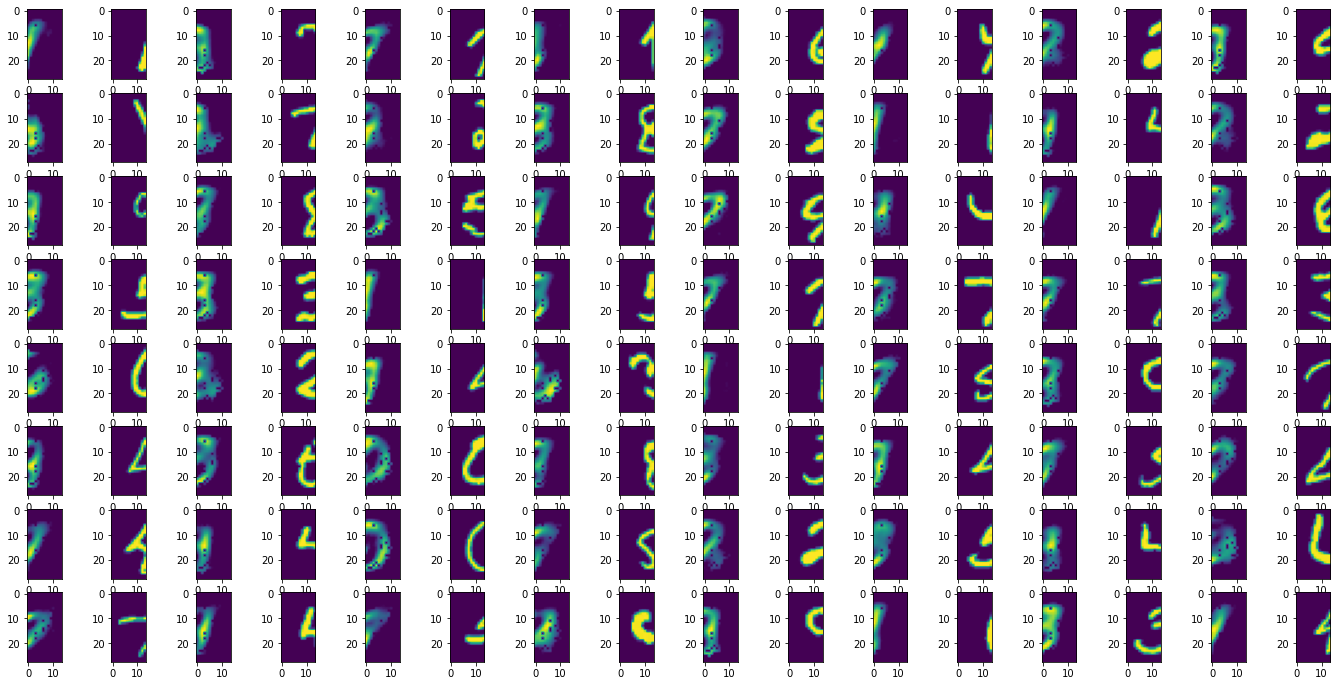

In [28]:
actual = x.cpu().detach().numpy()
right = right1.cpu().detach().numpy()
actual = actual[:,:,0,:,:].reshape(64,1,1,28,14)
actual = actual.squeeze()
right = right.squeeze()
print(actual.shape, right.shape)
show_sample_reconstructions(right, actual)

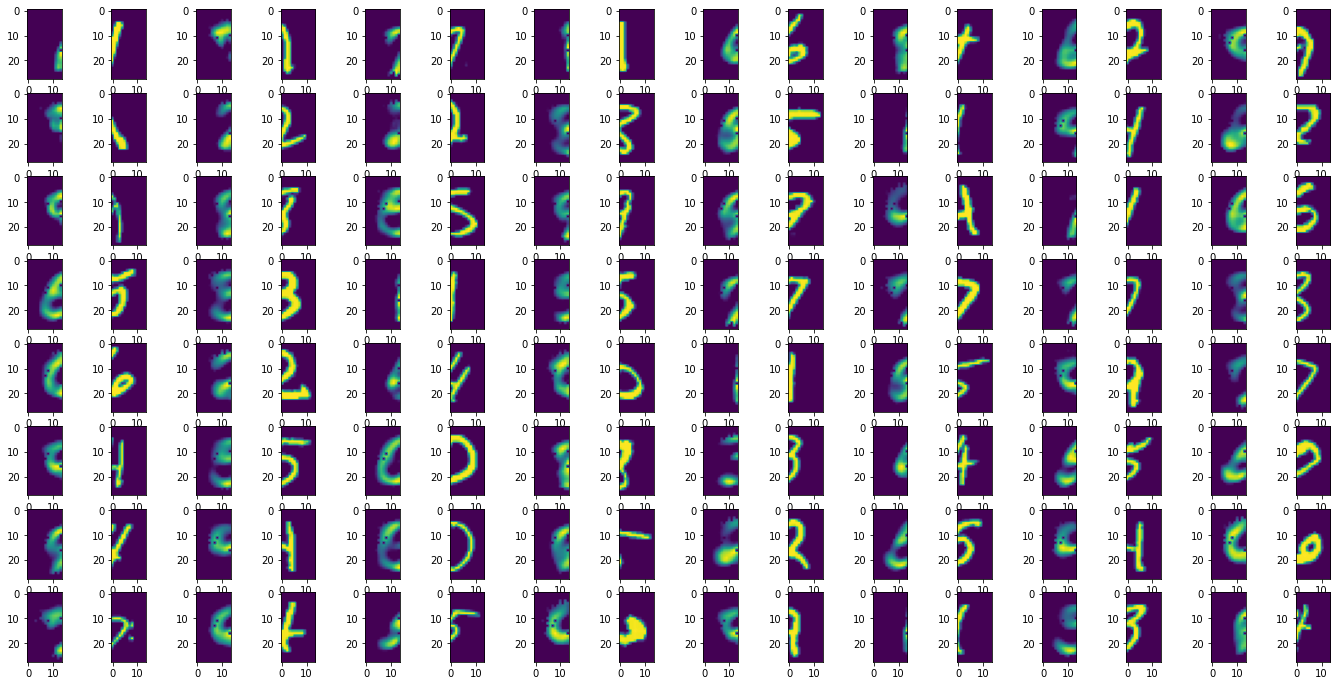

In [29]:
actual = x.cpu().detach().numpy()
left = left2.cpu().detach().numpy()
actual = actual[:,:,1,:,:].reshape(64,1,1,28,14)
actual = actual.squeeze()
left = left.squeeze()
show_sample_reconstructions(left, actual)